# Random Forest Model for Precipitation Prediction

This notebook implements a Random Forest model for binary rain prediction in Bissau, Guinea-Bissau.

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
)
from sktime.split import temporal_train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit


import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Data path
DATA_PATH = Path("../../0_data/bissau_merged.nc")

# Center cell indices (for 5x5 grid)
CENTER_LAT_IDX = 2
CENTER_LON_IDX = 2

# Rain threshold (mm)
RAIN_THRESHOLD = 0.1

print(f"Data path: {DATA_PATH}")
print(f"Rain threshold: {RAIN_THRESHOLD} mm")

Data path: ../../0_data/bissau_merged.nc
Rain threshold: 0.1 mm


In [3]:
# Load NetCDF4 with xarray
ds = xr.open_dataset(DATA_PATH)

# Convert timestamps to datetime
time_values = pd.to_datetime(ds.valid_time.values)

# Extract center cell data & apply unit conversions
t2m_center = ds.t2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
d2m_center = ds.d2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
tcc_center = ds.tcc[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 100  # fraction → %
sp_center = ds.sp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values / 100  # Pa → hPa
tp_center = ds.tp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 1000  # m → mm

# Create DataFrame with datetime index
df = pd.DataFrame(
    {
        "datetime": time_values,
        "t2m": t2m_center,  # Temperature (°C)
        "d2m": d2m_center,  # Dewpoint (°C)
        "tcc": tcc_center,  # Cloud cover (%)
        "sp": sp_center,  # Surface pressure (hPa)
        "tp": tp_center,  # Precipitation (mm)
    }
)
df.set_index("datetime", inplace=True)


# Calculate Relative Humidity using Magnus formula
def calc_relative_humidity(t2m, d2m):
    a, b = 17.625, 243.04
    rh = 100 * np.exp((a * d2m) / (b + d2m)) / np.exp((a * t2m) / (b + t2m))
    return np.clip(rh, 0, 100)


df["rh"] = calc_relative_humidity(df["t2m"].values, df["d2m"].values)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nBasic statistics:")
df.describe().round(2)

Data shape: (18263, 6)
Date range: 1975-01-01 00:00:00 to 2024-12-31 00:00:00

Basic statistics:


,t2m,d2m,tcc,sp,tp,rh
count,18263.00,18263.00,18263.00,18263.00,18263.00,18263.00
mean,24.93,20.85,56.09,1011.19,0.10,79.89
std,1.64,4.56,40.24,1.63,0.53,16.09
min,18.62,0.08,0.00,1005.20,0.00,21.22
25%,23.99,19.05,10.79,1010.07,0.00,74.01
50%,25.13,22.68,66.50,1011.18,0.00,86.25
75%,26.07,24.03,97.31,1012.32,0.00,91.38
max,31.38,27.67,100.00,1017.49,24.93,99.86


In [14]:
df.head()


,t2m,d2m,tcc,sp,tp,rh,rain_binary
datetime,,,,,,,
1975-01-01,23.901215,14.001129,31.664080,1008.002686,0.0,53.899139,0
1975-01-02,23.296295,21.144562,36.313396,1009.499207,0.0,87.722145,0
1975-01-03,24.607361,20.040924,9.092018,1010.639160,0.0,75.744820,0
1975-01-04,22.042206,18.102203,0.400352,1010.712708,0.0,78.363907,0
1975-01-05,21.983063,20.208405,100.000015,1010.250916,0.0,89.676521,0


## Binarize Target Variable

Create binary target: Rain (tp > 0.1mm) vs No Rain


BINARY TARGET DISTRIBUTION (threshold: 0.1 mm)

No Rain (0): 16,284 days (89.2%)
Rain (1):    1,979 days (10.8%)

Class imbalance ratio: 8.23:1


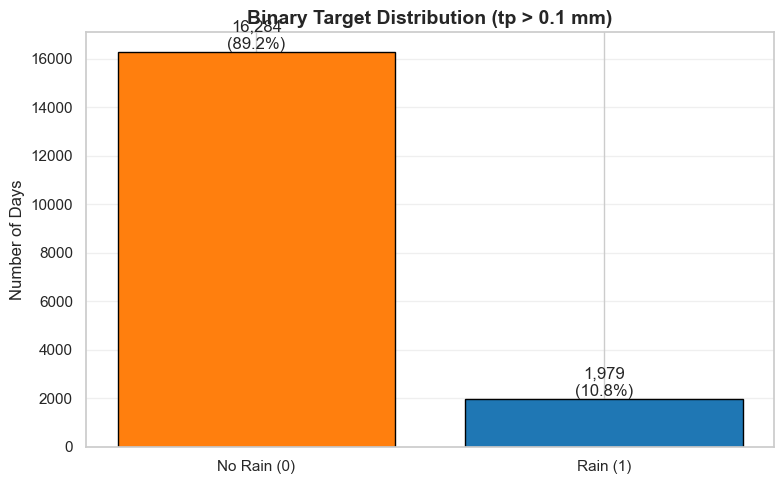

In [4]:
# Binarize precipitation: Rain vs No Rain
df["rain_binary"] = (df["tp"] > RAIN_THRESHOLD).astype(int)

# Check class distribution
class_counts = df["rain_binary"].value_counts()
class_pct = df["rain_binary"].value_counts(normalize=True) * 100

print("=" * 50)
print(f"BINARY TARGET DISTRIBUTION (threshold: {RAIN_THRESHOLD} mm)")
print("=" * 50)
print(f"\nNo Rain (0): {class_counts[0]:,} days ({class_pct[0]:.1f}%)")
print(f"Rain (1):    {class_counts[1]:,} days ({class_pct[1]:.1f}%)")
print(f"\nClass imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
colors = ["#ff7f0e", "#1f77b4"]
bars = ax.bar(
    ["No Rain (0)", "Rain (1)"], class_counts.values, color=colors, edgecolor="black"
)
ax.bar_label(
    bars,
    labels=[
        f"{c:,}\n({p:.1f}%)" for c, p in zip(class_counts.values, class_pct.values)
    ],
)
ax.set_ylabel("Number of Days")
ax.set_title(
    f"Binary Target Distribution (tp > {RAIN_THRESHOLD} mm)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Temporal Train/Val/Test Split (70/20/10)

Using sktime's `temporal_train_test_split` to preserve time ordering.


In [8]:
# For SARIMA, we work directly with the binary rain series
y = df["rain_binary"]

# Calculate split sizes
total = len(df)
train_size = int(total * 0.70)
val_size = int(total * 0.20)
test_size = total - train_size - val_size  # Remainder (~10%)

print(f"Total samples: {total:,}")
print(f"\nPlanned split:")
print(f"  Train: {train_size:,} ({train_size/total*100:.1f}%)")
print(f"  Val:   {val_size:,} ({val_size/total*100:.1f}%)")
print(f"  Test:  {test_size:,} ({test_size/total*100:.1f}%)")

Total samples: 18,263

Planned split:
  Train: 12,784 (70.0%)
  Val:   3,652 (20.0%)
  Test:  1,827 (10.0%)


In [9]:
# First split: train vs (val + test)
y_train, y_temp = temporal_train_test_split(y, test_size=(val_size + test_size))

# Second split: val vs test
y_val, y_test = temporal_train_test_split(y_temp, test_size=test_size)

print("=" * 60)
print("TEMPORAL SPLIT RESULTS")
print("=" * 60)
print(f"\nTrain set: {len(y_train):,} samples ({len(y_train)/total*100:.1f}%)")
print(f"  Date range: {y_train.index.min().date()} to {y_train.index.max().date()}")
print(f"  Rain days: {y_train.sum():,} ({y_train.mean()*100:.1f}%)")

print(f"\nValidation set: {len(y_val):,} samples ({len(y_val)/total*100:.1f}%)")
print(f"  Date range: {y_val.index.min().date()} to {y_val.index.max().date()}")
print(f"  Rain days: {y_val.sum():,} ({y_val.mean()*100:.1f}%)")

print(f"\nTest set: {len(y_test):,} samples ({len(y_test)/total*100:.1f}%)")
print(f"  Date range: {y_test.index.min().date()} to {y_test.index.max().date()}")
print(f"  Rain days: {y_test.sum():,} ({y_test.mean()*100:.1f}%)")

TEMPORAL SPLIT RESULTS

Train set: 12,784 samples (70.0%)
  Date range: 1975-01-01 to 2009-12-31
  Rain days: 1,388 (10.9%)

Validation set: 3,652 samples (20.0%)
  Date range: 2010-01-01 to 2019-12-31
  Rain days: 365 (10.0%)

Test set: 1,827 samples (10.0%)
  Date range: 2020-01-01 to 2024-12-31
  Rain days: 226 (12.4%)


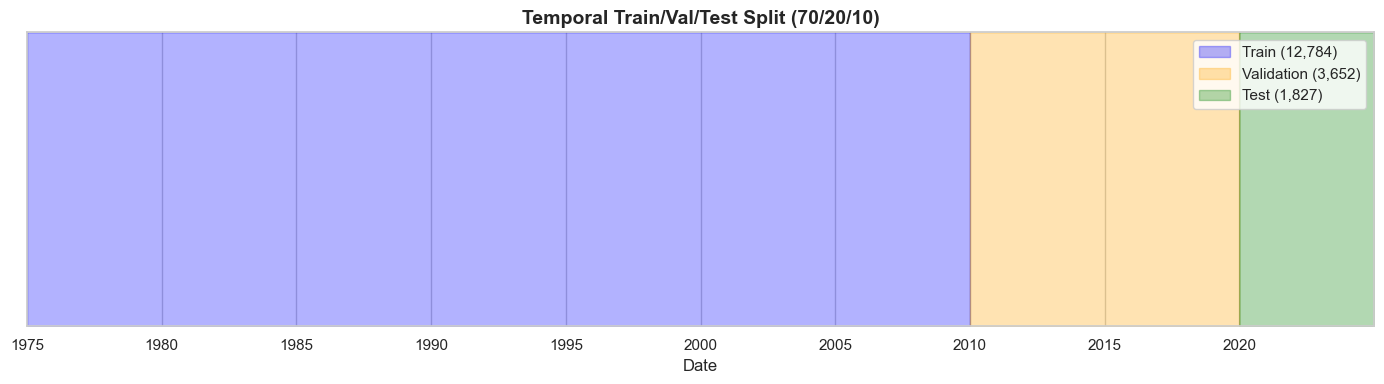

In [10]:
# Visualize the split
fig, ax = plt.subplots(figsize=(14, 4))

ax.fill_between(
    y_train.index, 0, 1, alpha=0.3, color="blue", label=f"Train ({len(y_train):,})"
)
ax.fill_between(
    y_val.index, 0, 1, alpha=0.3, color="orange", label=f"Validation ({len(y_val):,})"
)
ax.fill_between(
    y_test.index, 0, 1, alpha=0.3, color="green", label=f"Test ({len(y_test):,})"
)

ax.set_xlim(df.index.min(), df.index.max())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel("Date")
ax.set_title("Temporal Train/Val/Test Split (70/20/10)", fontsize=14, fontweight="bold")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Class Distribution by Split

Analyze the class distribution in each temporal split to understand potential distribution shifts.

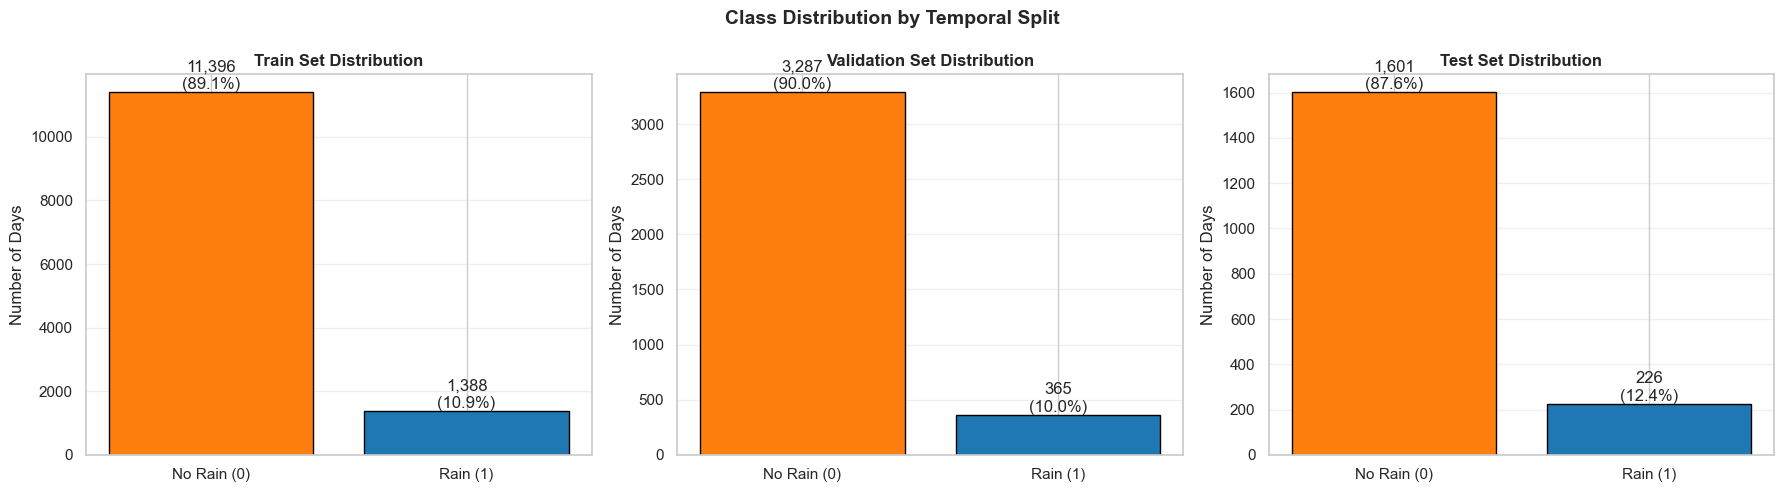

CLASS DISTRIBUTION SUMMARY BY SPLIT

Train Set:
  Total days: 12,784
  Rain days: 1,388 (10.9%)
  No rain days: 11,396 (89.1%)

Validation Set:
  Total days: 3,652
  Rain days: 365 (10.0%)
  No rain days: 3,287 (90.0%)

Test Set:
  Total days: 1,827
  Rain days: 226 (12.4%)
  No rain days: 1,601 (87.6%)


In [11]:
# Plot class distributions for each split
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = [
    ("Train", y_train),
    ("Validation", y_val),
    ("Test", y_test)
]

for ax, (name, y_split) in zip(axes, splits):
    class_counts_split = y_split.value_counts()
    class_pct_split = y_split.value_counts(normalize=True) * 100
    
    colors = ["#ff7f0e", "#1f77b4"]
    bars = ax.bar(
        ["No Rain (0)", "Rain (1)"], 
        class_counts_split.values, 
        color=colors, 
        edgecolor="black"
    )
    ax.bar_label(
        bars,
        labels=[
            f"{c:,}\n({p:.1f}%)" for c, p in zip(class_counts_split.values, class_pct_split.values)
        ],
    )
    ax.set_ylabel("Number of Days")
    ax.set_title(f"{name} Set Distribution", fontsize=12, fontweight="bold")
    ax.grid(axis="y", alpha=0.3)

plt.suptitle("Class Distribution by Temporal Split", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print summary
print("=" * 60)
print("CLASS DISTRIBUTION SUMMARY BY SPLIT")
print("=" * 60)
for name, y_split in splits:
    rain_pct = y_split.mean() * 100
    total_days = len(y_split)
    rain_days = y_split.sum()
    print(f"\n{name} Set:")
    print(f"  Total days: {total_days:,}")
    print(f"  Rain days: {rain_days:,} ({rain_pct:.1f}%)")
    print(f"  No rain days: {total_days - rain_days:,} ({100 - rain_pct:.1f}%)")

## Random Forest Model for Time Series Classification

Implement a Random Forest classifier using engineered time series features. We'll create lagged features from meteorological variables to predict next-day rain occurrence.


In [28]:
# Feature Engineering for Time Series Classification
# Create lagged features for all meteorological variables

def create_lagged_features(df, target_col='rain_binary', lags=7):
    """Create lagged features for time series prediction."""
    df_features = df.copy()
    
    # Features to lag
    feature_cols = ['t2m', 'd2m', 'tcc', 'sp', 'rh', 'tp']
    
    # Create lagged versions of features
    for lag in range(1, lags + 1):
        for col in feature_cols:
            df_features[f'{col}_lag_{lag}'] = df_features[col].shift(lag)
    
    # Create lagged target (for autoregression)
    for lag in range(1, lags + 1):
        df_features[f'rain_lag_{lag}'] = df_features[target_col].shift(lag)
    
    # Drop rows with NaN (due to lagging)
    df_features = df_features.dropna()
    
    return df_features

# Create features with 7-day lags
lags = 7
df_lagged = create_lagged_features(df, lags=lags)

print(f"Original data shape: {df.shape}")
print(f"Lagged data shape: {df_lagged.shape}")
print(f"Features created: {len(df_lagged.columns) - 1} (excluding target)")
print(f"Lag period: {lags} days")
print(f"Date range after lagging: {df_lagged.index.min().date()} to {df_lagged.index.max().date()}")

# Define features and target
feature_cols = [col for col in df_lagged.columns if (col != 'rain_binary' and col != 'tp')]
X = df_lagged[feature_cols]
y = df_lagged['rain_binary']

print(f"\nFeature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols[:10]):  # Show first 10
    print(f"  {col}")
if len(feature_cols) > 10:
    print(f"  ... and {len(feature_cols) - 10} more")


Original data shape: (18263, 7)
Lagged data shape: (18256, 56)
Features created: 55 (excluding target)
Lag period: 7 days
Date range after lagging: 1975-01-08 to 2024-12-31

Feature columns (54):
  t2m
  d2m
  tcc
  sp
  rh
  t2m_lag_1
  d2m_lag_1
  tcc_lag_1
  sp_lag_1
  rh_lag_1
  ... and 44 more


In [29]:
# Temporal Train/Val/Test Split for Features
# Since we created lagged features, we need to split the data temporally
# ensuring no data leakage

total_samples = len(X)
train_size = int(total_samples * 0.70)
val_size = int(total_samples * 0.20)
test_size = total_samples - train_size - val_size

print(f"Total samples after lagging: {total_samples:,}")
print(f"\nPlanned split:")
print(f"  Train: {train_size:,} ({train_size/total_samples*100:.1f}%)")
print(f"  Val:   {val_size:,} ({val_size/total_samples*100:.1f}%)")
print(f"  Test:  {test_size:,} ({test_size/total_samples*100:.1f}%)")

# Split indices
train_end = train_size
val_end = train_size + val_size

# Split features and target
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"\nActual split sizes:")
print(f"  Train: {len(X_train):,} samples")
print(f"  Val:   {len(X_val):,} samples")
print(f"  Test:  {len(X_test):,} samples")

print(f"\nDate ranges:")
print(f"  Train: {X_train.index.min().date()} to {X_train.index.max().date()}")
print(f"  Val:   {X_val.index.min().date()} to {X_val.index.max().date()}")
print(f"  Test:  {X_test.index.min().date()} to {X_test.index.max().date()}")

# Check class distributions in splits
print(f"\nClass distributions:")
print(f"  Train: {y_train.mean()*100:.1f}% rain days")
print(f"  Val:   {y_val.mean()*100:.1f}% rain days")
print(f"  Test:  {y_test.mean()*100:.1f}% rain days")


Total samples after lagging: 18,256

Planned split:
  Train: 12,779 (70.0%)
  Val:   3,651 (20.0%)
  Test:  1,826 (10.0%)

Actual split sizes:
  Train: 12,779 samples
  Val:   3,651 samples
  Test:  1,826 samples

Date ranges:
  Train: 1975-01-08 to 2010-01-02
  Val:   2010-01-03 to 2020-01-01
  Test:  2020-01-02 to 2024-12-31

Class distributions:
  Train: 10.9% rain days
  Val:   10.0% rain days
  Test:  12.4% rain days


In [ ]:
# Random Forest Model Training with Hyperparameter Tuning

# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

# Use TimeSeriesSplit for proper time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Use RandomizedSearchCV for efficiency
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,  # Try 50 random combinations
    cv=tscv,  # Time series cross-validation (no shuffling!)
    scoring='f1',  # Optimize for F1 score due to imbalance
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("=" * 60)
print("RANDOM FOREST HYPERPARAMETER TUNING")
print("=" * 60)
print(f"Parameter combinations to try: {len(grid_search.param_distributions['n_estimators']) * len(grid_search.param_distributions['max_depth']) * len(grid_search.param_distributions['min_samples_split']) * len(grid_search.param_distributions['min_samples_leaf']) * len(grid_search.param_distributions['max_features']) * len(grid_search.param_distributions['class_weight'])}")
print(f"Randomized search iterations: {grid_search.n_iter}")
print(f"Cross-validation: TimeSeriesSplit with {tscv.n_splits} splits (temporal order preserved)")
print(f"Scoring metric: {grid_search.scoring}")

# Fit the model on training data
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1 score: {grid_search.best_score_:.4f}")

# Get the best model
best_rf = grid_search.best_estimator_

RANDOM FOREST HYPERPARAMETER TUNING
Parameter combinations to try: 486
Randomized search iterations: 50
Cross-validation folds: 3
Scoring metric: f1
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [24]:
# Model Evaluation

# Predictions
y_train_pred = best_rf.predict(X_train)
y_train_proba = best_rf.predict_proba(X_train)[:, 1]

y_val_pred = best_rf.predict(X_val)
y_val_proba = best_rf.predict_proba(X_val)[:, 1]

y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate metrics
train_auc = roc_auc_score(y_train, y_train_proba)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("=" * 60)
print("RANDOM FOREST RESULTS")
print("=" * 60)
print(f"\n{'Set':<12} {'Accuracy':>10} {'F1 Score':>10} {'ROC AUC':>10}")
print("-" * 45)
print(f"{'Train':<12} {train_acc:>10.4f} {train_f1:>10.4f} {train_auc:>10.4f}")
print(f"{'Validation':<12} {val_acc:>10.4f} {val_f1:>10.4f} {val_auc:>10.4f}")
print(f"{'Test':<12} {test_acc:>10.4f} {test_f1:>10.4f} {test_auc:>10.4f}")


RANDOM FOREST RESULTS

Set            Accuracy   F1 Score    ROC AUC
---------------------------------------------
Train            1.0000     1.0000     1.0000
Validation       1.0000     1.0000     1.0000
Test             1.0000     1.0000     1.0000


In [25]:
# Classification Reports
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - VALIDATION SET")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=["No Rain (0)", "Rain (1)"]))

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - TEST SET")
print("=" * 60)
print(classification_report(y_test, y_test_pred, target_names=["No Rain (0)", "Rain (1)"]))

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "=" * 60)
print("TOP 20 FEATURE IMPORTANCES")
print("=" * 60)
print(feature_importance.head(20).to_string(index=False))



CLASSIFICATION REPORT - VALIDATION SET
              precision    recall  f1-score   support

 No Rain (0)       1.00      1.00      1.00      3286
    Rain (1)       1.00      1.00      1.00       365

    accuracy                           1.00      3651
   macro avg       1.00      1.00      1.00      3651
weighted avg       1.00      1.00      1.00      3651


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

 No Rain (0)       1.00      1.00      1.00      1600
    Rain (1)       1.00      1.00      1.00       226

    accuracy                           1.00      1826
   macro avg       1.00      1.00      1.00      1826
weighted avg       1.00      1.00      1.00      1826


TOP 20 FEATURE IMPORTANCES
  feature  importance
       tp         1.0
      t2m         0.0
 tp_lag_6         0.0
t2m_lag_5         0.0
d2m_lag_5         0.0
tcc_lag_5         0.0
 sp_lag_5         0.0
 rh_lag_5         0.0
 tp_lag_5         0.0
t2m_lag_6         0.0
d2

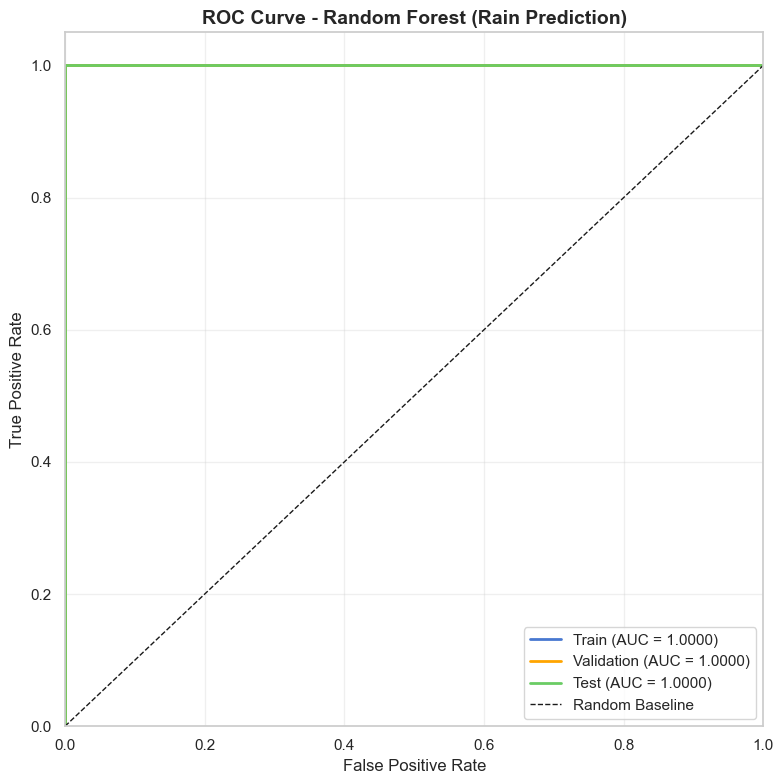

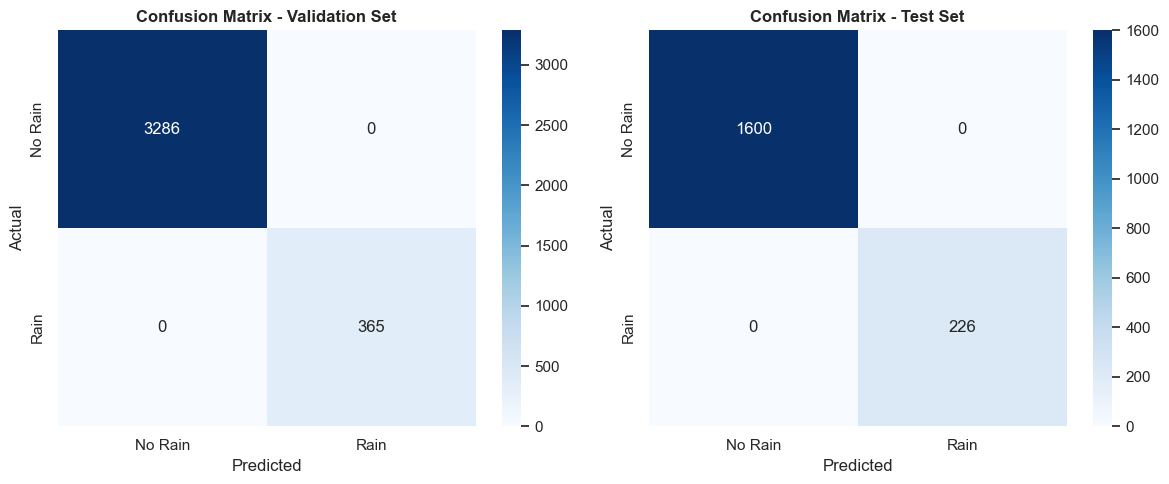

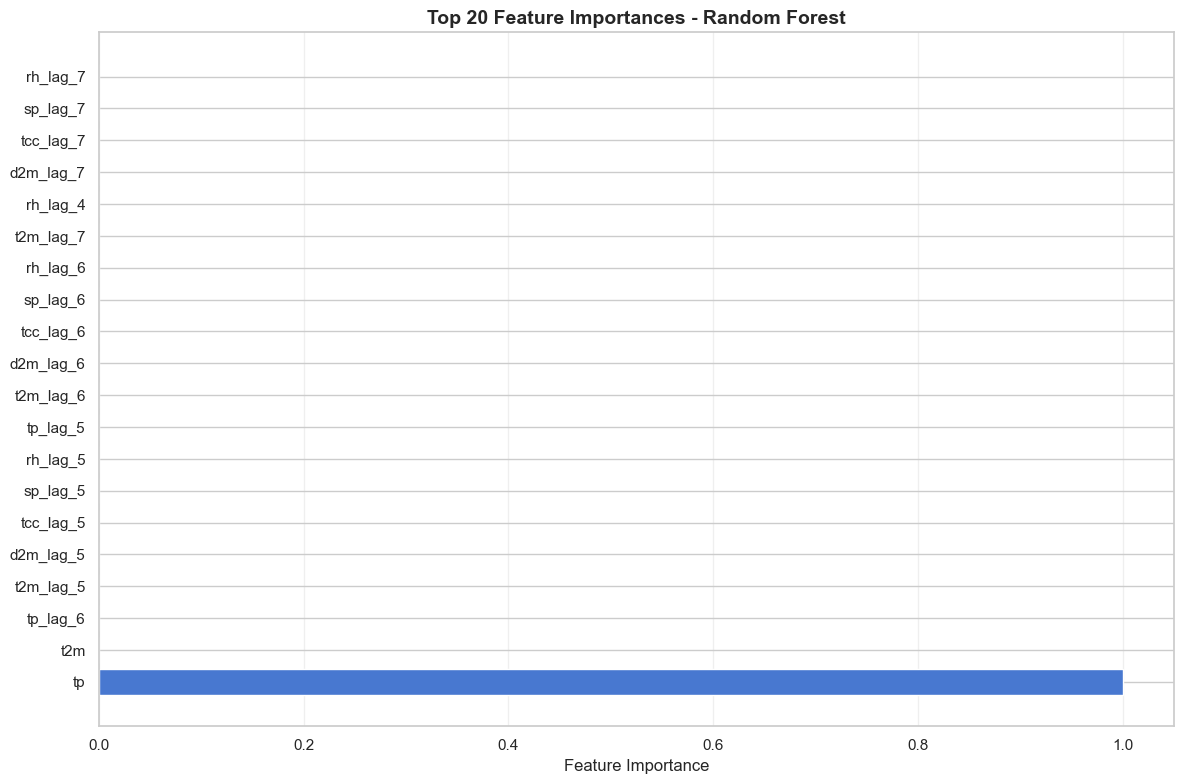

In [26]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 8))

# Train ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
ax.plot(fpr_train, tpr_train, "b-", lw=2, label=f"Train (AUC = {train_auc:.4f})")

# Validation ROC
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
ax.plot(fpr_val, tpr_val, "orange", lw=2, label=f"Validation (AUC = {val_auc:.4f})")

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
ax.plot(fpr_test, tpr_test, "g-", lw=2, label=f"Test (AUC = {test_auc:.4f})")

# Random baseline
ax.plot([0, 1], [0, 1], "k--", lw=1, label="Random Baseline")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curve - Random Forest (Rain Prediction)", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (y_true, y_pred_set, title) in zip(
    axes, [(y_val, y_val_pred, "Validation"), (y_test, y_test_pred, "Test")]
):
    cm = confusion_matrix(y_true, y_pred_set)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        xticklabels=["No Rain", "Rain"],
        yticklabels=["No Rain", "Rain"],
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix - {title} Set", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

# Feature importance plot
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 20 Feature Importances - Random Forest', fontsize=14, fontweight="bold")
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## Prediction Visualization

Visualize the model predictions on the test set.


In [ ]:
# Plot predictions over time for test set
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Test set - actual vs predicted probabilities
ax = axes[0]
ax.plot(X_test.index, y_test.values, 'b-', alpha=0.6, label='Actual', linewidth=0.8)
ax.plot(X_test.index, y_test_proba, 'r-', alpha=0.8, label='Predicted Probability', linewidth=0.8)
ax.axhline(y=0.5, color='green', linestyle='--', label='Threshold (0.5)')
ax.set_ylabel('Rain (0/1) / Probability')
ax.set_title('Test Set: Actual vs Predicted Probabilities', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

# Rolling accuracy over test period (30-day window)
ax = axes[1]
correct = (y_test.values == y_test_pred).astype(int)
rolling_acc = pd.Series(correct, index=X_test.index).rolling(30).mean()
ax.plot(rolling_acc.index, rolling_acc.values, 'purple', linewidth=1.5)
ax.axhline(y=test_acc, color='red', linestyle='--', label=f'Overall Accuracy ({test_acc:.3f})')
ax.set_ylabel('30-Day Rolling Accuracy')
ax.set_title('Test Set: Rolling Prediction Accuracy', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
ax.set_ylim(0, 1)

# Monthly prediction accuracy
ax = axes[2]
monthly_acc = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred
}, index=X_test.index)
monthly_metrics = monthly_acc.groupby(monthly_acc.index.to_period('M')).apply(
    lambda x: (x['actual'] == x['predicted']).mean()
)
ax.bar(range(len(monthly_metrics)), monthly_metrics.values, color='steelblue', edgecolor='black')
ax.set_xticks(range(len(monthly_metrics)))
ax.set_xticklabels([str(p) for p in monthly_metrics.index], rotation=45, ha='right')
ax.axhline(y=test_acc, color='red', linestyle='--', label=f'Overall Accuracy ({test_acc:.3f})')
ax.set_ylabel('Monthly Accuracy')
ax.set_title('Test Set: Monthly Prediction Accuracy', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Summary

In [ ]:
print("=" * 70)
print("PRECIPITATION PREDICTION MODEL SUMMARY (RANDOM FOREST)")
print("=" * 70)
print(f"\nData:")
print(f"  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau")
print(f"  Period: {df.index.min().date()} to {df.index.max().date()}")
print(f"  Total samples: {len(df):,} days")
print(f"  After lagging: {len(df_lagged):,} days")

print(f"\nTarget Variable:")
print(f"  Binary classification: Rain (tp > {RAIN_THRESHOLD} mm) vs No Rain")
print(f"  Class distribution: {df['rain_binary'].mean()*100:.1f}% rain days")

print(f"\nModel: Random Forest Classifier")
print(f"  - Features: {len(feature_cols)} lagged features ({lags} days)")
print(f"  - Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"    {param}: {value}")

print(f"\nResults:")
print(f"  {'Set':<12} {'Accuracy':>10} {'F1 Score':>10} {'ROC AUC':>10}")
print(f"  {'-'*45}")
print(f"  {'Train':<12} {train_acc:>10.4f} {train_f1:>10.4f} {train_auc:>10.4f}")
print(f"  {'Validation':<12} {val_acc:>10.4f} {val_f1:>10.4f} {val_auc:>10.4f}")
print(f"  {'Test':<12} {test_acc:>10.4f} {test_f1:>10.4f} {test_auc:>10.4f}")

print(f"\nModel Performance:")
print(f"  Best CV F1 Score: {grid_search.best_score_:.4f}")
print(f"  Out-of-bag score: {best_rf.oob_score_:.4f}" if hasattr(best_rf, 'oob_score_') else "")


PRECIPITATION PREDICTION MODEL SUMMARY (SARIMAX)

Data:
  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau
  Period: 1975-01-01 to 2024-12-31
  Total samples: 18,263 days

Target Variable:
  Binary classification: Rain (tp > 0.1 mm) vs No Rain
  Class distribution: 10.8% rain days

Model: SARIMAX
  - Order (p, d, q): (2, 0, 2)
  - Seasonality: Fourier terms (4 harmonics, period=365.25)
  - Optimal threshold: 0.0987

Results:
  Set            Accuracy   F1 Score    ROC AUC
  ---------------------------------------------
  Train            0.7431     0.4363     0.8777
  Validation       0.7555     0.4316     0.8827
  Test             0.7761     0.5054     0.8899

Model Information Criteria:
  AIC: 3292.84
  BIC: 3389.76
